# Методы отбора признаков

Датасет: https://www.kaggle.com/c/bioresponse/data

In [1]:
from __future__ import print_function

In [2]:
from tqdm import tqdm_notebook

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
df = pd.read_csv('data/train.csv', sep=',')
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.shape

(3751, 1777)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = \
    train_test_split(df.iloc[:, 1:].values, df.iloc[:, 0].values, test_size=0.3, random_state=9876)

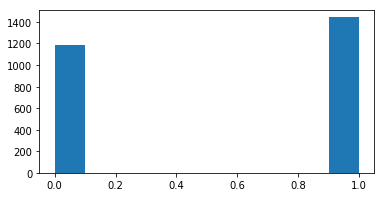

In [7]:
plt.figure(figsize=(6, 3))
_ = plt.hist(y_train)

In [8]:
from sklearn import linear_model, ensemble
from sklearn.metrics import roc_auc_score

## __1__. Признаки с низкой дисперсией

```python
from sklearn.feature_selection import VarianceThreshold
```

In [9]:
index = X_train.std(axis=0).argsort()
index

array([ 822,  800,  302, ...,  995, 1017, 1158])

In [10]:
scores_lm = []

for i in tqdm_notebook(range(0, X_train.shape[1], 10)):
    clf = linear_model.LogisticRegression(C=0.01)
    clf.fit(X_train[:, index[i:]], y_train)
    
    y_pred = clf.predict_proba(X_valid[:, index[i:]])[:, 1]
    scores_lm.append(roc_auc_score(y_valid, y_pred))
    
    if i < 150:
        n_features = index[i:].shape[0]
        print("features = {:>4d}; score = {:.6f}".format(n_features, scores_lm[-1]))

/home/v.bugaevskii/miniconda3/envs/ml-py27/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


features = 1776; score = 0.832565
features = 1766; score = 0.832565
features = 1756; score = 0.832578
features = 1746; score = 0.832578
features = 1736; score = 0.832584
features = 1726; score = 0.832581
features = 1716; score = 0.832568
features = 1706; score = 0.832581
features = 1696; score = 0.832578
features = 1686; score = 0.832594
features = 1676; score = 0.832562
features = 1666; score = 0.832578
features = 1656; score = 0.832571
features = 1646; score = 0.832568
features = 1636; score = 0.832571



In [11]:
scores_rf = []

for i in tqdm_notebook(range(0, X_train.shape[1], 10)):
    clf = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=8)
    clf.fit(X_train[:, index[i:]], y_train)
    
    y_pred = clf.predict_proba(X_valid[:, index[i:]])[:, 1]
    scores_rf.append(roc_auc_score(y_valid, y_pred))
    
    if i < 150:
        n_features = index[i:].shape[0]
        print("features = {:>4d}; score = {:.6f}".format(n_features, scores_rf[-1]))

features = 1776; score = 0.872727
features = 1766; score = 0.870247
features = 1756; score = 0.870376
features = 1746; score = 0.871716
features = 1736; score = 0.870694
features = 1726; score = 0.867290
features = 1716; score = 0.872748
features = 1706; score = 0.873958
features = 1696; score = 0.875703
features = 1686; score = 0.873460
features = 1676; score = 0.875897
features = 1666; score = 0.870456
features = 1656; score = 0.871288
features = 1646; score = 0.871265
features = 1636; score = 0.875437



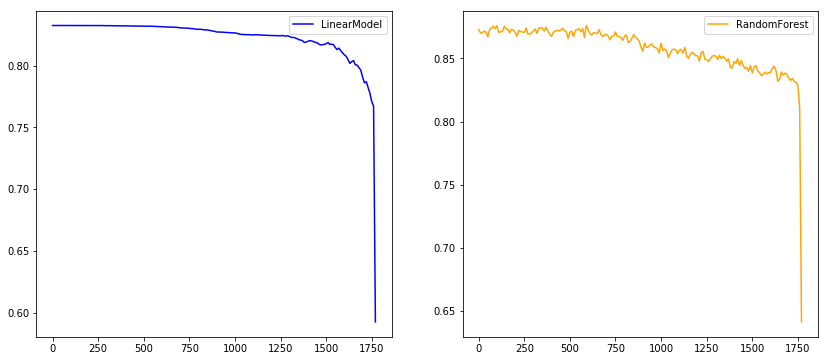

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(range(0, X_train.shape[1], 10), scores_lm, c='blue', label='LinearModel')
ax[1].plot(range(0, X_train.shape[1], 10), scores_rf, c='orange', label='RandomForest')

ax[0].legend()
ax[1].legend()

plt.show()

<span style="color:blue;font-weight:bold">Вопрос:</span> что будет, если применить метод после `StandardScaler`?

## __2__. С помощью дисперсионного анализа (ANOVA) и критерия Фишера

### T-критерий Стьюдента (для регрессии)

$$ X \theta = y$$

$$ X \in \mathbf{R}^{N \times m};~ \theta \in \mathbf{R}^m;~ y \in \mathbf{R}^N $$

$$ H_0: \theta_k =    \theta_{k0} $$
$$ H_1: \theta_k \neq \theta_{k0} $$

$$ T_k = \frac{\hat\theta_k - \theta_{k0}}{S_k} \sim St(N - m - 1)$$

$$ P(\left| T_k \right| > t(\alpha)) = \alpha $$

где
* $N$ – число примеров в обучающей выборке;
* $m$ – размерность признакового пространства;
* $S_k$ – [стандартная ошибка](https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%B0%D0%BD%D0%B4%D0%B0%D1%80%D1%82%D0%BD%D0%B0%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BA%D0%B0) коэффициента $\theta_k$.

Нас интересует случай $\theta_{k0} = 0$. 

### F-критерий Фишера (для регрессии)

$$ X \theta = y$$

$$ X \in \mathbf{R}^{N \times m};~ \theta \in \mathbf{R}^m;~ y \in \mathbf{R}^N $$

$$ H_0: A \theta = a $$
$$ H_1: A \theta \neq a $$

где
* $A \in \mathbf{R} ^ {p \times (m + 1)}$ – неслучайная матрица;
* $a \in \mathbf{R} ^ p$ – неслучайный вектор.

Представим
$$ y = \hat y_{UR} + e_{UR} $$
$$ y = \hat y_{R} + e_{R} $$
и обозначим $ESS_{UR} = \left| e_{UR} \right|^2$ и $ESS_{R} = \left| e_{R} \right|^2$.

$$ F = \frac{(ESS_{R} - ESS_{UR})/p}{ESS_{UR} / (N - m + 1)} \sim F(p, N - m - 1)$$

$$ P(F_k > f(\alpha)) = \alpha $$

Нас интерсует следующий вариант ограничений: $\theta_{k_1} = \theta_{k_2} = ... = \theta_{k_p} = 0$.

<span style="color:blue;font-weight:bold">Вопросы:</span>
1. В чем принципиальное отличие критерия Стьюдента от критерия Фишера?
2. Как можно применять критерий Стьюдента для поиска (не)значимых признаков?

```python
from sklearn.feature_selection import SelectKBest        # выбор по количеству переменных
from sklearn.feature_selection import SelectPercentile   # выбор по персентилю

from sklearn.feature_selection import chi2           # для категориальных переменных (классификация)
from sklearn.feature_selection import f_classif      # для непререрывных переменных (классификация)
from sklearn.feature_selection import f_regression   # для непререрывных переменных (регрессия)
```

In [13]:
from sklearn.feature_selection import f_classif

In [14]:
_, p_values = f_classif(X_train, y_train)
p_values[np.isnan(p_values)] = 1
index = p_values.argsort()[::-1]

/home/v.bugaevskii/miniconda3/envs/ml-py27/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [822] are constant.
  UserWarning)
/home/v.bugaevskii/miniconda3/envs/ml-py27/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [15]:
scores_lm = []

for i in tqdm_notebook(range(0, X_train.shape[1], 10)):
    clf = linear_model.LogisticRegression(C=0.01)
    clf.fit(X_train[:, index[i:]], y_train)
    
    y_pred = clf.predict_proba(X_valid[:, index[i:]])[:, 1]
    scores_lm.append(roc_auc_score(y_valid, y_pred))
    
    if i < 150:
        n_features = index[i:].shape[0]
        print("features = {:>4d}; score = {:.6f}".format(n_features, scores_lm[-1]))

features = 1776; score = 0.832565
features = 1766; score = 0.832631
features = 1756; score = 0.832420
features = 1746; score = 0.832388
features = 1736; score = 0.832344
features = 1726; score = 0.832404
features = 1716; score = 0.832264
features = 1706; score = 0.832619
features = 1696; score = 0.832815
features = 1686; score = 0.833558
features = 1676; score = 0.833821
features = 1666; score = 0.833774
features = 1656; score = 0.833514
features = 1646; score = 0.833410
features = 1636; score = 0.833596



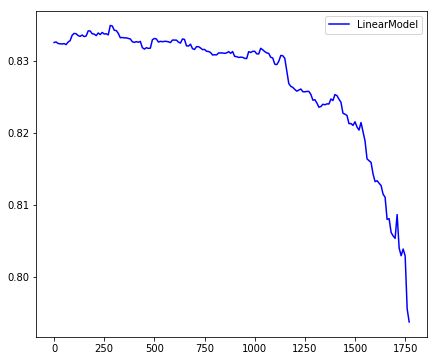

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.plot(range(0, X_train.shape[1], 10), scores_lm, c='blue', label='LinearModel')
ax.legend()

plt.show()

In [17]:
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(f_classif, k=X_train.shape[1] - np.argmax(scores_lm) * 10)
    
X_train_sel = selector.fit_transform(X_train, y_train)
X_valid_sel = selector.transform(X_valid)

clf = linear_model.LogisticRegression(C=0.01)
clf.fit(X_train_sel, y_train)
    
y_pred = clf.predict_proba(X_valid_sel)[:, 1]
roc_auc_score(y_valid, y_pred)

0.8349252853016271

```python
from sklearn.feature_selection import mutual_info_classif
```

В отличие от тестов выше данный вариант способен улавливать НЕлинейные связи. 

## __3__. На основе "важности" признаков

```python
from sklearn.feature_selection import SelectFromModel
```

### __3.1__. Lasso-регрессия (регрессия с l1-регуляризацией)

<span style="color:blue;font-weight:bold">Вопрос:</span> чем хороша l1-регуляризация?

In [40]:
clf = linear_model.LogisticRegression(C=1, penalty='l1')
clf.fit(X_train, y_train)
clf.coef_

array([[0., 0., 0., ..., 0., 0., 0.]])

In [41]:
(np.abs(clf.coef_) > 0).sum()

472

https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_path.html

In [42]:
from sklearn.svm import l1_min_c

c_grid = l1_min_c(X_train, y_train, loss='log') * np.logspace(0, 3, 100)

In [43]:
scores_lm, features_lm = [], []

for c in tqdm_notebook(c_grid):
    clf = linear_model.LogisticRegression(C=c, penalty='l1')
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict_proba(X_valid)[:, 1]
    scores_lm.append(roc_auc_score(y_valid, y_pred))
    
    n_features = (np.abs(clf.coef_) > 0).sum()
    features_lm.append(n_features)

/home/v.bugaevskii/miniconda3/envs/ml-py27/lib/python2.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


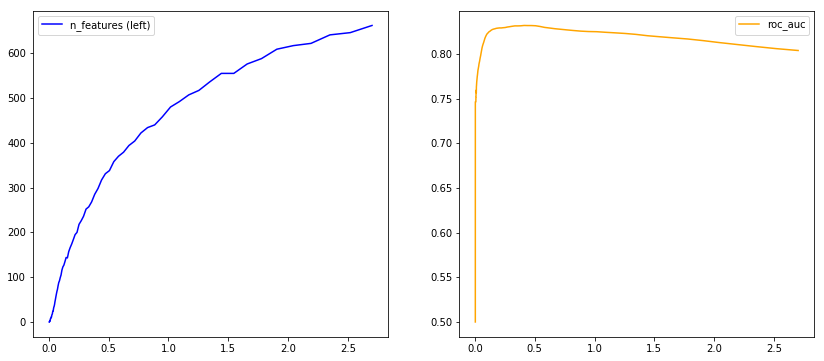

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(c_grid, features_lm, c='blue', label='n_features (left)')
# ax[0].plot(c_grid, X_train.shape[0] - np.asarray(features_lm), c='green', label='n_features (removed)')
ax[0].legend()
# ax[0].set_xscale('log')

ax[1].plot(c_grid, scores_lm, c='orange', label='roc_auc')
ax[1].legend()
# ax[1].set_xscale('log')

plt.show()

### __3.2__. Random Forest

In [69]:
clf = ensemble.RandomForestClassifier(n_estimators=300, random_state=9872)
clf.fit(X_train, y_train)
clf.feature_importances_

array([2.04926847e-03, 6.97207075e-03, 2.22589728e-03, ...,
       2.05919749e-05, 2.53175988e-05, 9.40062290e-06])

In [70]:
index = clf.feature_importances_.argsort()

In [71]:
scores_lm = []

for i in tqdm_notebook(range(0, X_train.shape[1], 10)):
    clf = linear_model.LogisticRegression(C=0.1)
    clf.fit(X_train[:, index[i:]], y_train)
    
    y_pred = clf.predict_proba(X_valid[:, index[i:]])[:, 1]
    scores_lm.append(roc_auc_score(y_valid, y_pred))
    
    if i < 150:
        n_features = index[i:].shape[0]
        print("features = {:>4d}; score = {:.6f}".format(n_features, scores_lm[-1]))

features = 1776; score = 0.836694
features = 1766; score = 0.836789
features = 1756; score = 0.836615
features = 1746; score = 0.836517
features = 1736; score = 0.836570
features = 1726; score = 0.836684
features = 1716; score = 0.836669
features = 1706; score = 0.836795
features = 1696; score = 0.836877
features = 1686; score = 0.836843
features = 1676; score = 0.836843
features = 1666; score = 0.836855
features = 1656; score = 0.836912
features = 1646; score = 0.836900
features = 1636; score = 0.836928



In [72]:
scores_rf = []

for i in tqdm_notebook(range(0, X_train.shape[1], 10)):
    clf = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=8)
    clf.fit(X_train[:, index[i:]], y_train)
    
    y_pred = clf.predict_proba(X_valid[:, index[i:]])[:, 1]
    scores_rf.append(roc_auc_score(y_valid, y_pred))
    
    if i < 150:
        n_features = index[i:].shape[0]
        print("features = {:>4d}; score = {:.6f}".format(n_features, scores_rf[-1]))

features = 1776; score = 0.869590
features = 1766; score = 0.872969
features = 1756; score = 0.869820
features = 1746; score = 0.870951
features = 1736; score = 0.875141
features = 1726; score = 0.871509
features = 1716; score = 0.876630
features = 1706; score = 0.869250
features = 1696; score = 0.871352
features = 1686; score = 0.872411
features = 1676; score = 0.874893
features = 1666; score = 0.868413
features = 1656; score = 0.867580
features = 1646; score = 0.872425
features = 1636; score = 0.869038



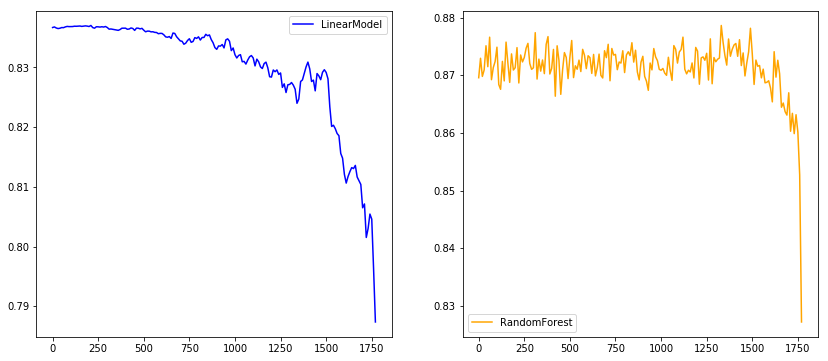

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(range(0, X_train.shape[1], 10), scores_lm, c='blue', label='LinearModel')
ax[1].plot(range(0, X_train.shape[1], 10), scores_rf, c='orange', label='RandomForest')

ax[0].legend()
ax[1].legend()

plt.show()

## __4__. Методы понижения размерности

* `SVD`-разложение;
* усеченное `SVD`-разложение (`TruncatedSVD`);
* `PCA` – метод главных компонент.

Визуализация PCA: http://setosa.io/ev/principal-component-analysis/

<span style="color:red;font-weight:bold">Важно:</span> PCA улавливает только линейную связь!

In [65]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
X_train_embedded = pca.fit_transform(X_train, y_train)
X_valid_embedded = pca.transform(X_valid)

In [66]:
pca.explained_variance_ratio_.sum()

0.8773139814392397

In [67]:
clf = linear_model.LogisticRegression(C=0.1)
clf.fit(X_train_embedded, y_train)

y_pred = clf.predict_proba(X_valid_embedded)[:, 1]
roc_auc_score(y_valid, y_pred)

0.8293980111937582

In [68]:
clf = ensemble.RandomForestClassifier(n_estimators=100)
clf.fit(X_train_embedded, y_train)

y_pred = clf.predict_proba(X_valid_embedded)[:, 1]
roc_auc_score(y_valid, y_pred)

0.8264524518380479

## __5__. Рекурсивный отбор признаков

* метод прямого отбора признаков;
* метод обратного отбора признаков.

```python
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE, RFECV
```


In [31]:
%%time

from sklearn.feature_selection import RFECV

clf = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=8)

rfecv = RFECV(estimator=clf, step=10, scoring="roc_auc", verbose=0)
rfecv.fit(X_train, y_train)

X_train_chosen = rfecv.transform(X_train)
X_valid_chosen = rfecv.transform(X_valid)

/home/v.bugaevskii/miniconda3/envs/ml-py27/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 11min 32s, sys: 41.1 s, total: 12min 13s
Wall time: 7min 15s


In [32]:
rfecv.n_features_

856

In [33]:
rfecv.support_

array([ True,  True,  True, ..., False, False, False])

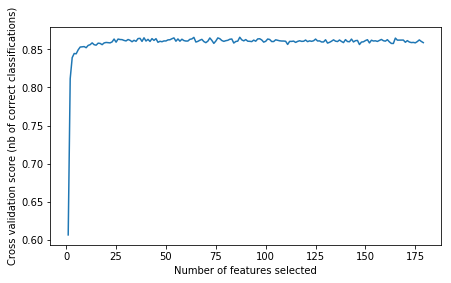

In [34]:
plt.figure(figsize=(7, 4))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [35]:
clf = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=8)
clf.fit(X_train_chosen, y_train)

y_pred = clf.predict_proba(X_valid_chosen)[:, 1]
roc_auc_score(y_valid, y_pred)

0.8716799179925903

In [36]:
clf = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=8)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, y_pred)

0.8738091998898975